## Baseline Model - RNN with complete backpropagation
- Using a RNN with 2 linear layers , with LogSoftMax as activation function. 
- Performing classification on the Digits dataset from sklearn.
- Results measured in logg loss (sum) and accuracy. 

Code (inspiration) I used :
- https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html
- https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627 
- Especially a lot of the code on github: https://github.com/jmtomczak/intro_dgm 

Errors i ran in to:
- https://nieznanm.medium.com/runtimeerror-one-of-the-variables-needed-for-gradient-computation-has-been-modified-by-an-inplace-85d0d207623



In [145]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.datasets import load_digits
from sklearn import datasets
import numpy as np
import os, sys, tarfile
import requests
import shutil
import torchvision
import numpy as np
from PIL import Image
from torchvision import transforms
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import random
from pytorch_model_summary import summary

### The Digits Dataset:

In [146]:
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode='train', transforms=None):
        digits = load_digits()
        if mode == 'train':
            self.data = digits.data[:1000].astype(np.float32)
            self.targets = digits.target[:1000]
        elif mode == 'val':
            self.data = digits.data[1000:1350].astype(np.float32)
            self.targets = digits.target[1000:1350]
        else:
            self.data = digits.data[1350:].astype(np.float32)
            self.targets = digits.target[1350:]
        
        self.transforms = transforms
        self.target_names = digits.target_names

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_x = self.data[idx]
        sample_y = self.targets[idx]
        if self.transforms:
            sample_x = self.transforms(sample_x)
        return (sample_x, sample_y)
    

In [147]:
# Initiliazing the data loaders for the digits dataset. 

train_data = Digits(mode='train')
val_data = Digits(mode='val')
test_data = Digits(mode='test')

LABELS = train_data.target_names

train_loader = DataLoader(train_data, batch_size=50, shuffle=True)
val_loader = DataLoader(val_data, batch_size=50, shuffle=False)
test_loader = DataLoader(test_data, batch_size=50, shuffle=False)

result_dir = 'results_baseline_wiebe/'
if not(os.path.exists(result_dir)):
    os.mkdir(result_dir)


1


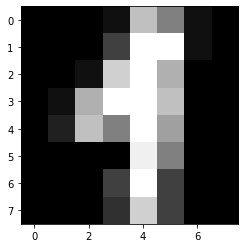

In [148]:
# Print an example digit and its according target label. - (digits dataset)

print(train_data.targets[90])
plottable_image = np.reshape(train_data.data[90], (8, 8))
plt.imshow(plottable_image, cmap='gray')

### The MNIST dataset

In [122]:
class MNIST(Dataset):
    """Complete MNIST dataset."""

    def __init__(self, mode='train', transforms=None):
        data_set_train = torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

        data_set_test = torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
        self.data = []
        self.targets = []
        
        if mode == 'train':
            for i in range(50000):
                self.data.append(data_set_train[i][0].numpy())
                self.targets.append(data_set_train[i][1])
        elif mode == 'val':
            for i in range(50000, 60000):
                self.data.append(data_set_train[i][0].numpy())
                self.targets.append(data_set_train[i][1])
        else:
            for i in range(len(data_set_test)):
                self.data.append(data_set_test[i][0].numpy())
                self.targets.append(data_set_test[i][1])
        
        self.targets = np.array(self.targets)
        self.data = np.array(self.data)
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_x = self.data[idx]
        sample_y = self.targets[idx]
        if self.transforms:
            sample_x = self.transforms(sample_x)
        return (sample_x, sample_y)

In [123]:
# Load in the MNIST dataset - (takes longer to load than Digits!, 6)
train_data_mnist = MNIST(mode='train')
val_data_mnist = MNIST(mode='val')
test_data_mnist = MNIST(mode='test')

train_loader_mnist = DataLoader(train_data_mnist, batch_size=50, shuffle=True)
val_loader_mnist = DataLoader(val_data_mnist, batch_size=50, shuffle=True)
test_loader_mnist = DataLoader(test_data_mnist, batch_size=50, shuffle=False)

1


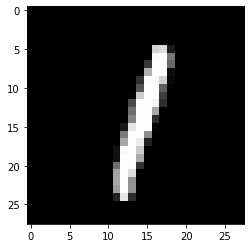

In [124]:
# Print an example MNIST digit and its according target label. - (digits dataset)

print(val_data_mnist.targets[1900])
plottable_image = np.reshape(val_data_mnist.data[1900], (28, 28))
plt.imshow(plottable_image, cmap='gray')

### The Baseline RNN 

In [149]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, T, dataset_MNIST = False):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.input_hidden_layer = nn.Linear(hidden_size, hidden_size)
        self.recurrent_layer = nn.Linear(input_size + hidden_size, hidden_size)
        self.output_layer = nn.Linear(input_size + hidden_size, output_size)
        
        self.f_0 = nn.Tanh()
        self.f_t = nn.ReLU(inplace=False)
        self.softmax = nn.LogSoftmax(dim=1)
        
        self.T = T
        
        # Initialize the weights
        self.input_hidden_layer.weight.data.uniform_(-0.01, 0.01)
        self.recurrent_layer.weight.data.uniform_(-0.01, 0.01)
        self.output_layer.weight.data.uniform_(-0.01, 0.01)
        
        self.mnist = dataset_MNIST

    def forward(self, input):
        
        # Initialize hidden input & hidden layer
        initial_hidden = torch.zeros(input.size()[0], self.hidden_size)
        hidden = self.f_0(self.input_hidden_layer(initial_hidden))
        
        for t in range(self.T):
            if self.mnist == False:  # So we use the Digits dataset
                combined = torch.cat((input, hidden), 1)  
                hidden = self.f_t(self.recurrent_layer(combined))
                
            elif self.mnist == True: # So we use the MNIST dataset
                
                # Squeeze the MNIST Tensor in 2 dimensions 
                three_d_tensor = input.squeeze(1)
                two_d_tensor = three_d_tensor.contiguous().view(three_d_tensor.size()[0], -1)  # 28 * 28 pixels = 784
                
                combined = torch.cat((two_d_tensor, hidden), 1)
                hidden = self.f_t(self.recurrent_layer(combined))
        
        
        output = self.output_layer(combined)
        y = self.softmax(output)
        
        return y
        


## Auxilary functions

In [150]:
# Function that transforms the tensor output to a predicted target name. 
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return LABELS[category_i]


# Plot both accuracy as log loss. 
def plot_results(epochs, loss, accuracy):
    fig, (ax1, ax2) = plt.subplots(2)
    fig.suptitle('Results RNN - Full Backpropagation.')
    ax1.set(ylabel='Loss')
    ax2.set(ylabel='Accuracy', xlabel='Epochs')
    
    ax1.plot(epochs, loss)
    ax2.plot(epochs, accuracy)
    

    plt.savefig('results_rnn_baseline.png', bbox_inches='tight')
    #plt.close()


# Concatenating the results of all (64*)batches in the lists, calculating the total accuracy. 
def accuracy(pred_targets_list, gold_targets_list):
    total_correct = 0
    total_amount = 0
    
    zip_list = zip(pred_targets_list, gold_targets_list)
    for pred_targets, gold_targets in zip_list:
        total_correct += (pred_targets == gold_targets).float().sum()
        total_amount += len(pred_targets)
    
    accuracy = 100 * total_correct / total_amount

    return accuracy.item()

# Evaluation -> used for validation and test set. 
def evaluation(val_loader, model, epoch, loss_function):
    
    #Evaluating our performance so far
    model.eval()
    
    # Store all results in a list to calculate the accuracy. 
    pred_target_total_acc = []
    target_total_acc = []
    
    # Initliaze dataset size and loss
    loss = 0.
    N = 0.
    
    # Iterating over the validation set batches, acquiring tensor formatted results. 
    for indx_batch, (batch, targets) in enumerate(val_loader):
        
        output = model.forward(batch)
        pred_targets = np.array([])
        for item in output:
            pred_targets = np.append(pred_targets, categoryFromOutput(item))
        pred_targets = torch.from_numpy(pred_targets).int()
        
        # Calculating loss
        loss_t = loss_function(output, targets.long())
        loss = loss + loss_t.item()
        N = N + batch.shape[0]
        
        #Append the batch result to a list of all results
        pred_target_total_acc.append(pred_targets)
        target_total_acc.append(targets)
    
    # Store the loss corrected by its size
    loss = loss / N   
        
    total_accuracy = accuracy(pred_target_total_acc, target_total_acc)
    print('Epoch: %s - Loss of: %s - Accuracy of: %s' %(epoch, loss,total_accuracy))
    
    return epoch, loss, total_accuracy

In [151]:
def training(model, train_loader, val_loader, num_epochs, optimizer, loss_function, max_loss_iter):
    
    print('Training started for %s epochs.'  %(num_epochs))
    epochs = []
    accuracy_results = []
    loss_results = []
    best_loss = 10000 # Picking random high number to assure correct functionality
    loss_iter = 0
    
    # Initialize hidden layers
    
    # Used for error detection
    #torch.autograd.set_detect_anomaly(True)

    for epoch in range(num_epochs):
        # Training
        model.train()
        
        # Processing batch by batch
        for indx_batch, (batch, targets) in enumerate(train_loader):

            output = model.forward(batch)
            
            targets = targets.long()
            
            loss = loss_function(output, targets)
            
            # Optional print of loss per batch
            #print('Loss in batch %s is: %s' %(indx_batch, loss))
        
            # Backpropagate after every batch feed - mini batch gradient descent
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()   
        
        # Perform evaluation after each epoch
        epoch, loss_eval, accuracy_eval = evaluation(val_loader, model, epoch, loss_function)
        epochs.append(epoch)
        accuracy_results.append(accuracy_eval)
        loss_results.append(loss_eval)
        
        if epoch == 0:
            print('* Saving 1st epoch model *')
            torch.save(model, 'trained_baseline.model')
            best_loss = loss_eval
        else:
            if loss_eval < best_loss:
                print('* Saving new best model *')
                torch.save(model, 'trained_baseline.model')
                best_loss = loss_eval
                loss_iter = 0
            else:
                loss_iter += 1
        
        # If loss has not improved for an arbitrary amount of epochs:
        if loss_iter > max_loss_iter:
            break
    
    plot_results(epochs, loss_results, accuracy_results)
    
    return model



## Parameter set-up

In [152]:
INPUT_SIZE_DIGITS = 64  # 8 * 8 pixels
INPUT_SIZE_MNIST = 784  # 28 * 28 pixels
BATCH_SIZE = 50 
n_hidden = 128
n_labels = 10
n_epochs = 50
lr_SGD = 0.0001
momentum_SGD = 0.9
max_loss_iter = 5
T = 5

## Initialize model/optimizer/loss_function. Start training.

Training started for 50 epochs.
Epoch: 0 - Loss of: 0.2792046397072928 - Accuracy of: 90.85713958740234
* Saving 1st epoch model *
Epoch: 1 - Loss of: 0.21628853389195032 - Accuracy of: 92.85713958740234
* Saving new best model *
Epoch: 2 - Loss of: 0.20007325785500663 - Accuracy of: 91.42857360839844
* Saving new best model *
Epoch: 3 - Loss of: 0.24961233956473214 - Accuracy of: 90.57142639160156
Epoch: 4 - Loss of: 0.1505894592830113 - Accuracy of: 95.71428680419922
* Saving new best model *
Epoch: 5 - Loss of: 0.16064211675098963 - Accuracy of: 95.42857360839844
Epoch: 6 - Loss of: 0.15476391247340612 - Accuracy of: 96.28571319580078
Epoch: 7 - Loss of: 0.14290993962969098 - Accuracy of: 96.28571319580078
* Saving new best model *
Epoch: 8 - Loss of: 0.14542310578482492 - Accuracy of: 95.42857360839844
Epoch: 9 - Loss of: 0.1492321137019566 - Accuracy of: 95.71428680419922
Epoch: 10 - Loss of: 0.13939771447862898 - Accuracy of: 96.28571319580078
* Saving new best model *
Epoch: 11 

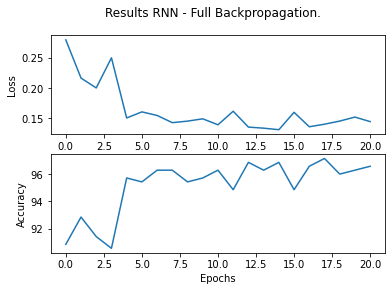

In [154]:
# Perform training on the DIGITS dataset
model = RNN(INPUT_SIZE_DIGITS, n_hidden, n_labels, T, dataset_MNIST = False)
optimizer = optim.SGD([p for p in model.parameters() if p.requires_grad == True], lr=lr_SGD, momentum=momentum_SGD)
loss_function = nn.NLLLoss(reduction='sum') # Mean is also possible.

trained_model = training(model, train_loader, val_loader, n_epochs, optimizer, loss_function, max_loss_iter)


Training started for 50 epochs.
Epoch: 0 - Loss of: 2.295183115386963 - Accuracy of: 13.600000381469727
* Saving 1st epoch model *
Epoch: 1 - Loss of: 2.295183110046387 - Accuracy of: 13.600000381469727
* Saving new best model *
Epoch: 2 - Loss of: 2.295183110046387 - Accuracy of: 13.600000381469727
Epoch: 3 - Loss of: 2.295183097076416 - Accuracy of: 13.600000381469727
* Saving new best model *
Epoch: 4 - Loss of: 2.295183112335205 - Accuracy of: 13.600000381469727
Epoch: 5 - Loss of: 2.295183106994629 - Accuracy of: 13.600000381469727
Epoch: 6 - Loss of: 2.2951831268310547 - Accuracy of: 13.600000381469727
Epoch: 7 - Loss of: 2.295183111572266 - Accuracy of: 13.600000381469727
Epoch: 8 - Loss of: 2.2951830978393555 - Accuracy of: 13.600000381469727
Epoch: 9 - Loss of: 2.295183090209961 - Accuracy of: 13.600000381469727
* Saving new best model *
Epoch: 10 - Loss of: 2.295183113861084 - Accuracy of: 13.600000381469727
Epoch: 11 - Loss of: 2.2951831008911134 - Accuracy of: 13.6000003814

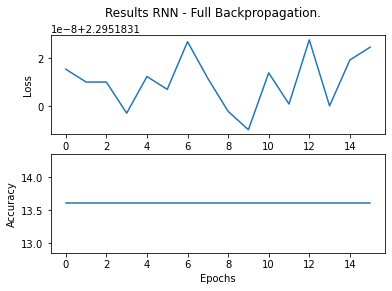

In [139]:
# Perform training on the MNIST dataset
model_mnist = RNN(INPUT_SIZE_MNIST, n_hidden, n_labels, T, dataset_MNIST = True)
optimizer = optim.SGD([p for p in model.parameters() if p.requires_grad == True], lr=0.5, momentum=0.9)
loss_function_mnist = nn.NLLLoss(reduction='sum') # Mean is also possible.

trained_model_mnist = training(model_mnist, train_loader_mnist, val_loader_mnist, n_epochs, optimizer, loss_function_mnist, max_loss_iter)

In [140]:
# Summary of the RNN model:
print(summary(model, torch.zeros(50, 64), show_input=True, show_hierarchical=False))

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Linear-1           [50, 128]          16,512          16,512
            Tanh-2           [50, 128]               0               0
          Linear-3           [50, 192]          24,704          24,704
            ReLU-4           [50, 128]               0               0
          Linear-5           [50, 192]          24,704          24,704
            ReLU-6           [50, 128]               0               0
          Linear-7           [50, 192]          24,704          24,704
            ReLU-8           [50, 128]               0               0
          Linear-9           [50, 192]          24,704          24,704
           ReLU-10           [50, 128]               0               0
         Linear-11           [50, 192]          24,704          24,704
           ReLU-12           [50, 128]               0               0
     

## Analyze our performance on the test set:

In [141]:
test_result = evaluation(test_loader, trained_model, 'Final score', loss_function)

Epoch: Final score - Loss of: 0.4261775390147096 - Accuracy of: 89.48545837402344


In [142]:
test_result_mnist = evaluation(test_loader_mnist, trained_model_mnist, 'Final score', loss_function_mnist)

Epoch: Final score - Loss of: 2.2948246070861815 - Accuracy of: 13.829999923706055
